In [228]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
cat = CatBoostRegressor()
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
import matplotlib

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns

## Train, Test 전처리

In [229]:
data = pd.read_excel("G:\내 드라이브\Github\BigContest_Flood-ZERO/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210902_update.xlsx" )

In [230]:
data.columns = ['홍수사상번호','연', '월', '일', '시간','유입량',
'유역평균강수1','강우A1','강우B1','강우C1','강우D1','수위E1','수위D1',
'유역평균강수2','강우A2','강우B2','강우C2','강우D2','수위E2','수위D2',
'유역평균강수3','강우A3','강우B3','강우C3','강우D3','수위E3','수위D3',
'유역평균강수4','강우A4','강우B4','강우C4','강우D4','수위E4','수위D4',
'유역평균강수5','강우A5','강우B5','강우C5','강우D5','수위E5','수위D5',
'유역평균강수6','강우A6','강우B6','강우C6','강우D6','수위E6','수위D6']

In [231]:
train = data.iloc[1:2892]

In [232]:
train.head()

,홍수사상번호,연,월,일,시간,유입량,유역평균강수1,강우A1,강우B1,강우C1,...,강우D5,수위E5,수위D5,유역평균강수6,강우A6,강우B6,강우C6,강우D6,수위E6,수위D6
1,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4,7,7,7,...,8,2.54,122.66,6.4,7,7,8,8,2.54,122.61
2,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.6
3,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.59
4,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3,7,10,7,...,14,2.53,122.62,11.3,9,10,15,14,2.53,122.585
5,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [233]:
test = data.iloc[2892:]
test = test.reset_index().drop(['index'],axis =1)

In [234]:
test.to_csv('test.csv', index = False)
train.to_csv('train.csv', index = False)

In [235]:
train = train.astype(float)
test = test.astype(float)

---

## Submission 전처리

In [236]:
submission = pd.read_excel("G:/내 드라이브/Github/BigContest_Flood-ZERO/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx" )

In [237]:
submission = submission.iloc[1:]
submission = submission.reset_index().drop(['index'],axis =1)

In [238]:
유역평균강수 = ['유역평균강수1','유역평균강수2','유역평균강수3','유역평균강수4','유역평균강수5','유역평균강수6']
강우A = ['강우A1','강우A2','강우A3','강우A4','강우A5','강우A6']
강우B = ['강우B1','강우B2','강우B3','강우B4','강우B5','강우B6']
강우C = ['강우C1','강우C2','강우C3','강우C4','강우C5','강우C6']
강우D = ['강우D1','강우D2','강우D3','강우D4','강우D5','강우D6']
수위E = ['수위E1','수위E2','수위E3','수위E4','수위E5','수위E6']
수위D = ['수위D1','수위D2','수위D3','수위D4','수위D5','수위D6']

---

- 홍수사상번호별로 정규화된 인덱스를 추가

- 주어진 홍수사상번호 1 ~ 25번에서 홍수사상번호 1 ~ 21번을 train set, 22 ~ 25번을 test set로 임의로 나누어 점수를 비교하며 변수가 유의미한지 체크하였다.
    
    - 집단별로 다중공선성이 있다고 판단하여, 하나의 집단만을 사용하기위해 점수를 가장 잘 예측하는 집단을 체크하여 사용
    - 수위D의 상관계수가 0.1로 낮아, 변수의 유무에 따른 점수차이를 체크
    - 온도가 증발량과 관련이 있을것으로 판단하여 온도변수의 유무에 따른 점수차이를 체크
    
    - 다른 모델(XGBoost, LGBM)과 점수차이 체크
    - 학습후, 예측할때 다른 집단 데이터를 사용한 점수차이 체크

---
## train 1~25 홍수사상번호별 정규화된 인덱스 추가

In [239]:
X = train.drop('유입량', axis=1)
y = train['유입량']

In [240]:
X_1 = X.iloc[:226]
X_2 = X.iloc[226:326]
X_3 = X.iloc[326:407]
X_4 = X.iloc[407:441]
X_5 = X.iloc[441:535]
X_6 = X.iloc[535:581]
X_7 = X.iloc[581:632]
X_8 = X.iloc[632:673]
X_9 = X.iloc[673:741]
X_10 = X.iloc[741:827]
X_11 = X.iloc[827:937]
X_12 = X.iloc[937:1064]
X_13 = X.iloc[1064:1131]
X_14 = X.iloc[1131:1181]
X_15 = X.iloc[1181:1443]
X_16 = X.iloc[1443:1648]
X_17 = X.iloc[1648:1773]
X_18 = X.iloc[1773:1838]
X_19 = X.iloc[1838:1933]
X_20 = X.iloc[1933:2197]
X_21 = X.iloc[2197:2281]
X_22 = X.iloc[2281:2565]
X_23 = X.iloc[2565:2694]
X_24 = X.iloc[2694:2788]
X_25 = X.iloc[2788:2891]

In [241]:
dtlists = []
index = pd.DataFrame()
for j in range(1, 26):
    eval('dtlists.append(X_'+str(j)+')')
    dtlists[j-1] = dtlists[j-1].reset_index()
    dtlists[j-1]['인덱스'] = dtlists[j-1].index
    dtlists[j-1]['정규화인덱스'] = dtlists[j-1]['인덱스'] / (len(dtlists[j-1])-1)
    index = pd.concat([index, pd.DataFrame(dtlists[j-1])])
    
index = index.reset_index()
train['정규화인덱스'] = index['정규화인덱스']

## test 26번 홍수사상번호정규화된 인덱스 추가

In [242]:
test['인덱스'] = test.index
test['정규화인덱스'] = test['인덱스'] / (len(test)-1)

- 홍수사상번호별로 시간의 흐름에 따라 유입량을 살펴본 결과, 처음과 끝은 유입량이 적고 중간이 가장 높은 경향을 보였다.

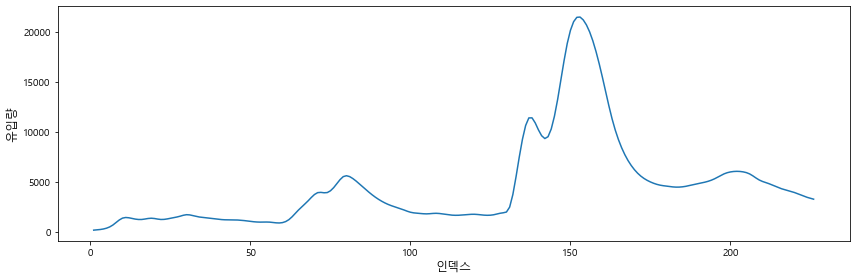

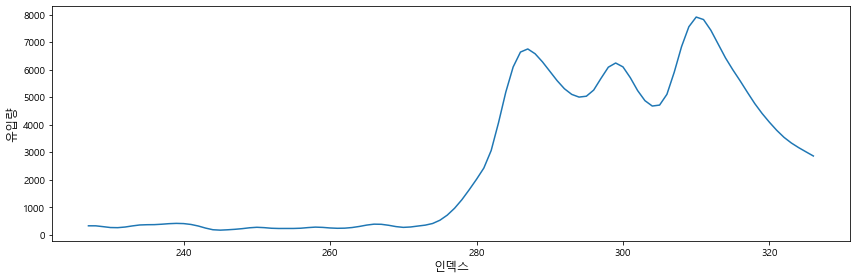

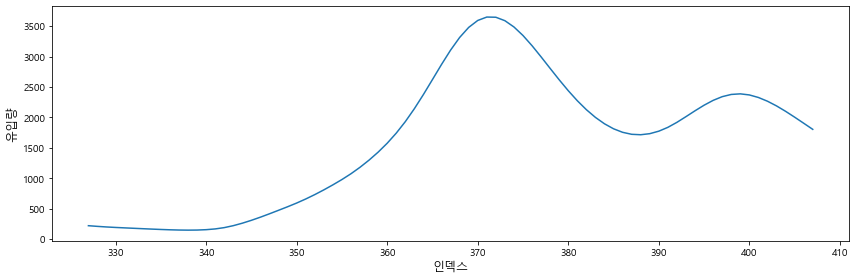

In [243]:
for i in range(1, 4):
    plt.figure(figsize=(12,4))
    eval('plt.plot(train.query(\'홍수사상번호=='+str(i)+'\').index, train.query(\'홍수사상번호=='+str(i)+'\')[\'유입량\'])')
    plt.ylabel('유입량', size=12)
    plt.xlabel('인덱스', size=12)
    plt.tight_layout()

- 이러한 경향을 학습시키기 위하여 인덱스 변수를 추가하였다.
- 홍수사상번호별로 행의 갯수가 다르기에 모두 인덱스변수를 정규화하여 사용하였다.

---

## 점수 예측을 위한 임시 train(홍수사상번호 1 ~ 21) / test(홍수사상번호 22 ~ 25) 분리

In [244]:
X_train, X_test, y_train, y_test = train_test_split(train[['정규화인덱스',*유역평균강수, *강우A, *강우B, *강우C, *강우D, *수위E, *수위D]],
                                                           train['유입량'], test_size=0.2109996, shuffle=False)

Original_train = X_train # 사상번호 1 ~ 21
Original_test = X_test # 사상번호 22 ~ 25

---
## 집단별 점수 비교

In [245]:
X = X.drop(['홍수사상번호', '연', '일', '시간'], axis=1)

X_1_1 = X.drop(X.iloc[:, 8:], axis=1)
X_1_1 = X_1_1.iloc[:226]

X_1_2 = X.drop(X.iloc[:, 1:8], axis=1)
X_1_2 = X_1_2.drop(X.iloc[:, 15:], axis=1)
X_1_2 = X_1_2.iloc[:226]

In [246]:
corrs = pd.DataFrame(index=X_1_2.drop(['월'], axis=1).columns, columns=X_1_1.drop(['월'], axis=1).columns)

In [247]:
for i in range(7):
    corrs.iloc[:, i] = pd.to_numeric(corrs.iloc[:, i])

In [248]:
for i in range(0, 7):
    for j in range(0, 7):
        corrs.iloc[i, j] = np.corrcoef(train.iloc[:, j+6], train.iloc[:, i+13])[0, 1]

<AxesSubplot:>

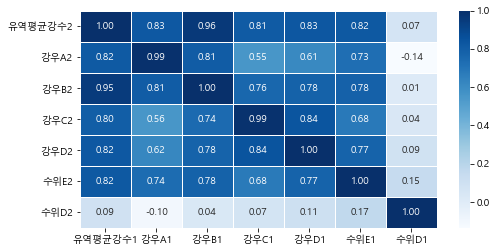

In [249]:
plt.figure(figsize=(8,4))
sns.heatmap(corrs, annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

- 집단간에 상관계수를 비교해봤을때, 상관계수가 매우 높다. 이 변수들을 모두 사용했을때, 다중공선성이 있을 것이라 판단하여 집단을 하나만 사용하였다.

### 집단 1

In [250]:
X_train = Original_train[[유역평균강수[0], 강우A[0], 강우B[0], 강우C[0], 강우D[0], 수위E[0], 수위D[0]]]
X_test = Original_test[[유역평균강수[0], 강우A[0], 강우B[0], 강우C[0], 강우D[0], 수위E[0], 수위D[0]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [251]:
pred = model.predict(X_test)

In [252]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

759.7370959418506

### 집단 2

In [253]:
X_train = Original_train[[유역평균강수[1], 강우A[1], 강우B[1], 강우C[1], 강우D[1], 수위E[1], 수위D[1]]]
X_test = Original_test[[유역평균강수[1], 강우A[1], 강우B[1], 강우C[1], 강우D[1], 수위E[1], 수위D[1]]]

categorical_features_indices1 = np.where(X_train.dtypes == np.object)[0]

model = cat
model.fit(X_train, y_train, silent=True)

In [254]:
pred = model.predict(X_test)

In [255]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

803.1710778071422

### 집단 3

In [256]:
X_train = Original_train[[유역평균강수[2], 강우A[2], 강우B[2], 강우C[2], 강우D[2], 수위E[2], 수위D[2]]]
X_test = Original_test[[유역평균강수[2], 강우A[2], 강우B[2], 강우C[2], 강우D[2], 수위E[2], 수위D[2]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [257]:
pred = model.predict(X_test)

In [258]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

792.0017813608149


### 집단 4

In [259]:
X_train = Original_train[[유역평균강수[3], 강우A[3], 강우B[3], 강우C[3], 강우D[3], 수위E[3], 수위D[3]]]
X_test = Original_test[[유역평균강수[3], 강우A[3], 강우B[3], 강우C[3], 강우D[3], 수위E[3], 수위D[3]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [260]:
pred = model.predict(X_test)

In [261]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

704.6983613897916


### 집단 5

In [262]:
X_train = Original_train[[유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위E[4], 수위D[4]]]
X_test = Original_test[[유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위E[4], 수위D[4]]]

categorical_features_indices1 = np.where(X_train.dtypes == np.object)[0]

model = cat
model.fit(X_train, y_train, silent=True)

In [263]:
pred = model.predict(X_test)

In [264]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

670.9822236789764

### 집단 6

In [265]:
X_train = Original_train[[유역평균강수[5], 강우A[5], 강우B[5], 강우C[5], 강우D[5], 수위E[5], 수위D[5]]]
X_test = Original_test[[유역평균강수[5], 강우A[5], 강우B[5], 강우C[5], 강우D[5], 수위E[5], 수위D[5]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [266]:
pred = model.predict(X_test)

In [267]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

780.2260861941985

- 집단 5의 점수가 가장 좋게나와서 집단5만을 사용하였다.

---
## 수위 D의 유무에 따른 점수 비교

In [268]:
# 집단 1개만을 사용한 상관계수 비교
data = train[['유입량', '유역평균강수1', '강우A1', '강우B1', '강우C1',
       '강우D1', '수위E1', '수위D1']]
data.corr()['유입량']

유입량        1.000000
유역평균강수1    0.742268
강우A1       0.617424
강우B1       0.739951
강우C1       0.605588
강우D1       0.700568
수위E1       0.903840
수위D1       0.109475
Name: 유입량, dtype: float64

- 수위D의 상관계수가 0.1로 매우 낮다

### 수위D 안넣었을 때

In [269]:
X_train = Original_train[[유역평균강수[4],강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위E[4]]]
X_test = Original_test[[유역평균강수[4],강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위E[4]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [270]:
pred = model.predict(X_test)

In [271]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

795.6776213730046

### 수위D 넣었을 때

In [272]:
X_train = Original_train[[유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]
X_test = Original_test[[유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [273]:
pred = model.predict(X_test)

In [274]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

648.5832381659743

- 수위D를 넣는게 더 좋게 나와서 수위D를 그대로 사용하였다.

---
## 다른 모델과 점수차이 비교

In [275]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### XGBoostRegressor

In [276]:
X_train = Original_train[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]
X_test = Original_test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [277]:
pred = model.predict(X_test)

In [278]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

552.0518058209736

### LGBMRegressor

In [279]:
X_train = Original_train[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]
X_test = Original_test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]

model = LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [280]:
pred = model.predict(X_test)

In [281]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

538.0813745593989

### CatBoostRegressor

In [282]:
X_train = Original_train[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]
X_test = Original_test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]

model = cat
model.fit(X_train, y_train, silent=True)

In [283]:
pred = model.predict(X_test)

In [284]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, pred))))
rmse

421.1103896772417

XGBoost : 552.0518058209736

LGBM : 538.0813745593989

CatBoost : `421.1103896772417`
    
- CatBoost의 rmse가 가장 우수했다.

---
## 학습은 5로 시킨 뒤, 각각의 집단 데이터를 이용해 예측 후 산술평균

In [285]:
X_train = Original_train[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]
X_test = Original_test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]

model = cat
model.fit(X_train, y_train, silent = True)

X_test = Original_test[['정규화인덱스', 유역평균강수[0], 강우A[0], 강우B[0], 강우C[0], 강우D[0],수위D[0], 수위E[0]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred1 = model.predict(X_test)

X_test = Original_test[['정규화인덱스', 유역평균강수[1], 강우A[1], 강우B[1], 강우C[1], 강우D[1],수위D[1], 수위E[1]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred2 = model.predict(X_test)

X_test = Original_test[['정규화인덱스', 유역평균강수[2], 강우A[2], 강우B[2], 강우C[2], 강우D[2],수위D[2], 수위E[2]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred3 = model.predict(X_test)

X_test = Original_test[['정규화인덱스', 유역평균강수[3], 강우A[3], 강우B[3], 강우C[3], 강우D[3],수위D[3], 수위E[3]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred4 = model.predict(X_test)

X_test = Original_test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred5 = model.predict(X_test)

X_test = Original_test[['정규화인덱스', 유역평균강수[5], 강우A[5], 강우B[5], 강우C[5], 강우D[5],수위D[5], 수위E[5]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred6 = model.predict(X_test)

In [286]:
mean_preds = (pred1 + pred2 + pred3 + pred4 + pred5 + pred6) / 6

In [287]:
rmse = (np.sqrt(np.mean(mean_squared_error(y_test, mean_preds))))
rmse

420.4005862789978

집단5만 데이터로만 예측했을때 421.1103896772417

전체데이터를 이용하여 평균냈을때 420.4005862789978

---
# predict

In [288]:
# X_train = train[['정규화인덱스',유역평균강수[4],강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]
# y_train = train['유입량']

# model = cat
# model.fit(X_train, y_train, silent=True)

In [289]:
# pred = model.predict(test)

In [290]:
X_train = train[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]
y_train = train['유입량']
X_test = test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4], 수위D[4], 수위E[4]]]

model = cat
model.fit(X_train, y_train, silent = True)

X_test = test[['정규화인덱스', 유역평균강수[0], 강우A[0], 강우B[0], 강우C[0], 강우D[0],수위D[0], 수위E[0]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred1 = model.predict(X_test)

X_test = test[['정규화인덱스', 유역평균강수[1], 강우A[1], 강우B[1], 강우C[1], 강우D[1],수위D[1], 수위E[1]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred2 = model.predict(X_test)

X_test = test[['정규화인덱스', 유역평균강수[2], 강우A[2], 강우B[2], 강우C[2], 강우D[2],수위D[2], 수위E[2]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred3 = model.predict(X_test)

X_test = test[['정규화인덱스', 유역평균강수[3], 강우A[3], 강우B[3], 강우C[3], 강우D[3],수위D[3], 수위E[3]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred4 = model.predict(X_test)

X_test = test[['정규화인덱스', 유역평균강수[4], 강우A[4], 강우B[4], 강우C[4], 강우D[4],수위D[4], 수위E[4]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred5 = model.predict(X_test)

X_test = test[['정규화인덱스', 유역평균강수[5], 강우A[5], 강우B[5], 강우C[5], 강우D[5],수위D[5], 수위E[5]]]
X_test.columns=['정규화인덱스', '유역평균강수5', '강우A5', '강우B5', '강우C5', '강우D5', '수위D5', '수위E5'] # 열 이름 감제 병합
pred6 = model.predict(X_test)

pred = (pred1+pred2+pred3+pred4+pred5+pred6)/6

In [291]:
submission['유입량'] = pred

In [292]:
submission

,홍수사상번호,연,월,일,시간,유입량
0,26.0,2018.0,7.0,1.0,6.0,161.757403
1,26.0,2018.0,7.0,1.0,7.0,175.444868
2,26.0,2018.0,7.0,1.0,8.0,225.567232
3,26.0,2018.0,7.0,1.0,9.0,337.321496
4,26.0,2018.0,7.0,1.0,10.0,480.617630
...,...,...,...,...,...,...
155,26.0,2018.0,7.0,7.0,17.0,514.537086
156,26.0,2018.0,7.0,7.0,18.0,512.645909
157,26.0,2018.0,7.0,7.0,19.0,508.232045
158,26.0,2018.0,7.0,7.0,20.0,509.100612


In [293]:
submission.to_csv('submission.csv', index = False)